In [73]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud, STOPWORDS
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import graphviz
import plotly.express as px
from collections import OrderedDict

pd.options.display.max_rows = 10

# !pip install wordcloud
# !pip install -U scikit-learn
# nltk.download('stopwords')
# nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

In [74]:
#predictPy
class Analisis_Predictivo:

    def __init__(self, datos: pd.DataFrame, predecir: str, predictoras=[],
                 modelo=None, estandarizar = True,train_size=0.75, random_state=None):
        '''
        datos: Datos completos y listos para construir un modelo   

        predecir: Nombre de la variable a predecir

        predictoras: Lista de los nombres de las variables predictoras.
        Si vacío entonces utiliza todas las variables presentes excepto la variable a predecir.

        modelo: Instancia de una Clase de un método de clasificación(KNN,Árboles,SVM,etc).
        Si no especifica un modelo no podrá utilizar el método fit

        estandarizar: Indica si se debe o no estandarizar los datos que utilizará el estimador.

        train_size: Si el valor es tipo flotante entre 0.0 y 1.0 entonces representa la proporción de la tabla de entrenamiento.
        Si el valor es un entero entonces representa el valor absoluto de la tabla de entrenamiento.

        random_state: Semilla aleatoria para la división de datos(training-testing).
        '''
        self.__datos = datos
        self.__predecir = predecir
        self.__predictoras = predictoras
        self.__nombre_clases = list(np.unique(self.__datos[predecir].values))
        self.__modelo = modelo
        self.__random_state = random_state
        if modelo != None:
            self.__train_size = train_size
            self._training_testing(estandarizar)
    
    @property
    def datos(self):
        return self.__datos
    
    @property
    def predecir(self):
        return self.__predecir
    
    @property
    def predictoras(self):
        return self.__predictoras
    
    @property
    def nombre_clases(self):
        return self.__nombre_clases
    
    @property
    def modelo(self):
        return self.__modelo
    
    @property
    def random_state(self):
        return self.__random_state
    
    @property
    def train_size(self):
        return self.__train_size
    
    @datos.setter
    def datos(self, datos):
        self.__datos = datos
    
    @predecir.setter
    def predecir(self, predecir):
        self.__predecir = predecir
        
    @predictoras.setter
    def predictoras(self, predictoras):
        self.__predictoras = predictoras
        
    @nombre_clases.setter
    def nombre_clases(self, nombre_clases):
        self.__nombre_clases = nombre_clases
        
    @modelo.setter
    def modelo(self, modelo):
        self.__modelo = modelo
        
    @random_state.setter
    def random_state(self, random_state):
        self.__random_state = random_state
        
    @train_size.setter
    def train_size(self, train_size):
        self.__train_size = train_size
        
    def _training_testing(self, estandarizar = True):
        if len(self.predictoras) == 0:
            X = self.datos.drop(columns=[self.predecir])
            self.predictoras = list(X.columns.values)
        else:
            X = self.datos[self.predictoras]

        if estandarizar:
            X = pd.DataFrame(StandardScaler().fit_transform(X), columns= X.columns)

        y = self.datos[self.predecir].values

        train_test = train_test_split(X, y, train_size=self.train_size,
                                      random_state=self.random_state)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test

    def fit_predict(self):
        if(self.modelo != None):
            self.modelo.fit(self.X_train, self.y_train)
            return self.modelo.predict(self.X_test)

    def fit_predict_resultados(self, imprimir=True):
        if(self.modelo != None):
            prediccion = self.fit_predict()
            MC = confusion_matrix(self.y_test, prediccion, labels= self.nombre_clases)
            indices = self.indices_general(MC, self.nombre_clases)
            if imprimir == True:
                for k in indices:
                    print("\n%s:\n%s" % (k, str(indices[k])))

            return indices

    def indices_general(self, MC, nombres=None):
        "Método para calcular los índices de calidad de la predicción"
        precision_global = np.sum(MC.diagonal()) / np.sum(MC)
        error_global = 1 - precision_global
        precision_categoria = pd.DataFrame(MC.diagonal()/np.sum(MC, axis=1)).T
        if nombres != None:
            precision_categoria.columns = nombres
        return {"Matriz de Confusión": MC,
                "Precisión Global": precision_global,
                "Error Global": error_global,
                "Precisión por categoría": precision_categoria}

    def distribucion_variable_predecir(self, ax=None):
        "Método para graficar la distribución de la variable a predecir"
        variable_predict = self.predecir
        data = self.datos
        if ax == None:
            fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=200)
        colors = list(dict(**mcolors.CSS4_COLORS))
        df = pd.crosstab(index=data[variable_predict],
                         columns="valor") / data[variable_predict].count()
        countv = 0
        titulo = "Distribución de la variable %s" % variable_predict
        for i in range(df.shape[0]):
            ax.barh(1, df.iloc[i], left=countv, align='center',
                    color=colors[11+i], label=df.iloc[i].name)
            countv = countv + df.iloc[i]
        ax.set_xlim(0, 1)
        ax.set_yticklabels("")
        ax.set_ylabel(variable_predict)
        ax.set_title(titulo)
        ticks_loc = ax.get_xticks().tolist()
        ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
        ax.set_xticklabels(['{:.0%}'.format(x) for x in ticks_loc])
        countv = 0
        for v in df.iloc[:, 0]:
            ax.text(np.mean([countv, countv+v]) - 0.03, 1,
                    '{:.1%}'.format(v), color='black', fontweight='bold')
            countv = countv + v
        ax.legend(loc='upper center', bbox_to_anchor=(
            1.08, 1), shadow=True, ncol=1)

    def poder_predictivo_categorica(self, var: str, ax=None):
        "Método para ver la distribución de una variable categórica respecto a la predecir"
        data = self.datos
        variable_predict = self.predecir
        if ax == None:
            fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=200)
        df = pd.crosstab(index=data[var], columns=data[variable_predict])
        df = df.div(df.sum(axis=1), axis=0)
        titulo = "Distribución de la variable %s según la variable %s" % (
            var, variable_predict)
        df.plot(kind='barh', stacked=True, legend=True,
                ax=ax, xlim=(0, 1), title=titulo, width=0.8)
        ticks_loc = ax.get_xticks().tolist()
        ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
        ax.set_xticklabels(['{:.0%}'.format(x) for x in ticks_loc])
        ax.legend(loc='upper center', bbox_to_anchor=(
            1.08, 1), shadow=True, ncol=1)
        for bars in ax.containers:
            plt.setp(bars, width=.9)
        for i in range(df.shape[0]):
            countv = 0
            for v in df.iloc[i]:
                ax.text(np.mean([countv, countv+v]) - 0.03, i, '{:.1%}'.format(v),
                        color='black', fontweight='bold')
                countv = countv + v

    def poder_predictivo_numerica(self, var: str):
        "Función para ver la distribución de una variable numérica respecto a la predecir"
        sns.FacetGrid(self.datos, hue=self.predecir, height=8, aspect=1.8).map(
            sns.kdeplot, var, shade=True).add_legend()

#Función para calcular los índices de calidad de la predicción
def indices_general(MC, nombres = None):
    precision_global = np.sum(MC.diagonal()) / np.sum(MC)
    error_global     = 1 - precision_global
    precision_categoria  = pd.DataFrame(MC.diagonal()/np.sum(MC,axis = 1)).T
    if nombres!=None:
        precision_categoria.columns = nombres
    return {"Matriz de Confusión":MC, 
            "Precisión Global":   precision_global, 
            "Error Global":       error_global, 
            "Precisión por categoría":precision_categoria}

In [75]:
class MetricsCalculator:
    def __init__(self, confusion_matrix):
        self.confusion_matrix = confusion_matrix

    def calculate_metrics(self):
        tn, fp, fn, tp = self.confusion_matrix

        precision_global = (tp + tn) / sum(self.confusion_matrix)
        error_global = 1 - precision_global

        precision_positiva = tp / (fn + tp)
        precision_negativa = tn / (tn + fp)

        metrics_dict = {
            "Precisión Global": precision_global,
            "Error Global": error_global,
            "Precisión Positiva": precision_positiva,
            "Precisión Negativa": precision_negativa
        }

        return metrics_dict

## Data Reading

In [76]:
data = pd.read_csv('C:/Users/uriar/OneDrive/Fátima Uriarte/Fati Files/Trabajo Remoto/11. BID/Data Scientist/Task2/2. COP28 dataset.csv', delimiter=',', decimal='.',  encoding='utf-8')
print("Data COP28: ", data.shape, "\n")

Data COP28:  (9627, 45) 



In [77]:
# Filter the DataFrame to keep only the rows where 'Domain' is equal to 'twitter.com'
data = data[data['Domain'] == 'twitter.com']
print("Data COP28: ", data.shape, "\n")

Data COP28:  (9617, 45) 



## Variable Selection

In [78]:
# Create a new column 'Engagement Category' with a value of 0 if the engagement score is 0, and 1 for the rest
data['Engagement Category'] = data['Engagement Score'].apply(lambda x: 0 if x == 0 else 1)
data['Engagement Category'] = data['Engagement Category'].astype('category')

In [79]:
# Create a new column named 'Has_Hashtags' that indicates whether there are hashtags in the tweet content
data['Has_Hashtags'] = data['Snippet'].apply(lambda x: 1 if '#' in x else 0)

In [80]:
# Extract the hour from the 'Post Date' column
data['Post Date'] = pd.to_datetime(data['Post Date'])
data['Hour'] = data['Post Date'].dt.hour

In [81]:
# Create a new column named 'Tweet Length' that contains the length of each tweet
data['Tweet Length'] = data['Full Text'].apply(lambda x: len(x))

In [82]:
# Relevant Variables
columnas_a_incluir = ['Sentiment', 'Country Code', 'Language','Account Type', 'Author', 'Engagement Score', 'Twitter Followers', 'Has_Hashtags', 'Hour', 'Tweet Length', 'Twitter Tweets', 'Gender', 'Impact',  'Impressions', 'Reach', 'Engagement Category', 'Full Text' ]
datos = data[columnas_a_incluir]

## Exploratory Data Analysis

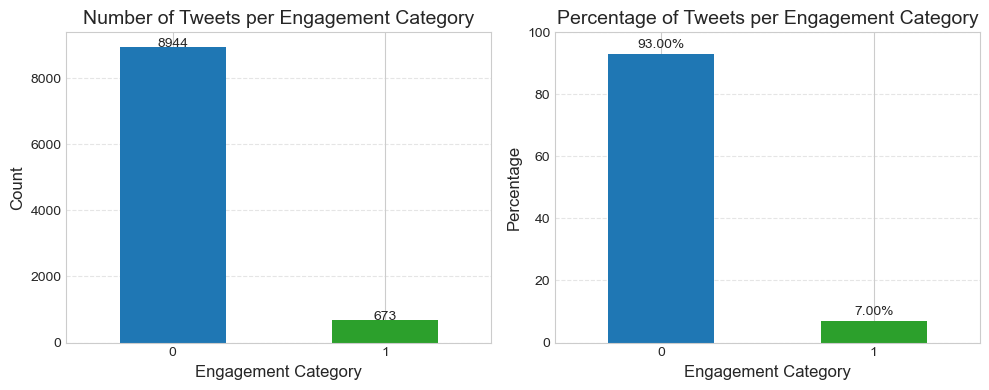

In [83]:
counts = data['Engagement Category'].value_counts()
percentage = data['Engagement Category'].value_counts(normalize=True) * 100

# Bar graph
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
counts.plot(kind='bar', color=['#1f77b4', '#2ca02c'], width=0.5, edgecolor='none')
plt.title('Number of Tweets per Engagement Category', fontsize=14)
plt.xlabel('Engagement Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='both', length=0)
plt.tight_layout()

for i, val in enumerate(counts):
    plt.text(i, val + 2, val, ha='center', fontsize=10)

plt.subplot(1, 2, 2)
percentage.plot(kind='bar', color=['#1f77b4', '#2ca02c'], width=0.5, edgecolor='none')
plt.title('Percentage of Tweets per Engagement Category', fontsize=14)
plt.xlabel('Engagement Category', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='both', length=0)
plt.tight_layout()

# Data
for i, val in enumerate(percentage):
    plt.text(i, val + 2, f'{val:.2f}%', ha='center', fontsize=10)

plt.show()


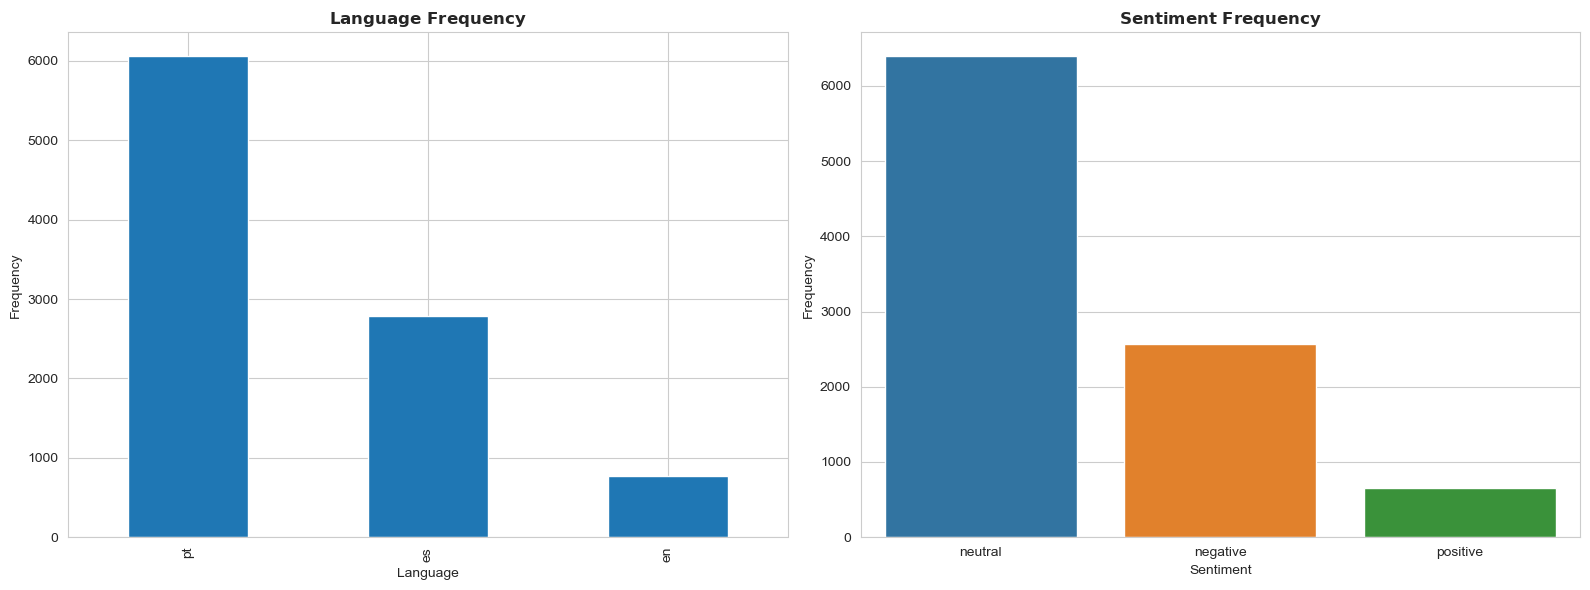

In [84]:
# Set the style
sns.set_style("whitegrid")

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the Language frequency
datos['Language'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title(r'$\bf{Language\ Frequency}$')  # Bold title
axes[0].set_xlabel('Language')
axes[0].set_ylabel('Frequency')

# Plot the Sentiment frequency
sns.countplot(data=datos, x='Sentiment', order=datos['Sentiment'].value_counts().index, ax=axes[1])
axes[1].set_title(r'$\bf{Sentiment\ Frequency}$')  # Bold title
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=0)

# Show the plots
plt.tight_layout()
plt.show()


In [85]:
# Numeric Summary
df0 = datos.drop(['Sentiment', 'Language', 'Country Code', 'Author', 'Gender','Engagement Category', 'Has_Hashtags', 'Account Type', 'Full Text'], axis=1)
summary = df0.describe().transpose()  # Transponer para una mejor visualización
print("Numeric Summary:")
print(summary.to_string())

Numeric Summary:
                    count          mean            std   min      25%      50%       75%         max
Engagement Score   9617.0     11.527503     244.709444   0.0      0.0      0.0       0.0     13848.0
Twitter Followers  9617.0  55890.137881  772356.355567   0.0    369.0   1292.0    3802.0  55179191.0
Hour               9617.0     13.737132       6.188604   0.0     11.0     15.0      18.0        23.0
Tweet Length       9617.0    256.732557      70.456560  34.0    221.0    289.0     317.0       663.0
Twitter Tweets     9617.0  97338.390246  187497.487908   3.0  13218.0  41010.0  105382.0   3022935.0
Impact             9617.0     10.145773      17.557540   0.0      0.0      0.0      15.5        99.6
Impressions        9617.0  69072.195487  852930.248318   0.0    372.0   1297.0    3886.0  55230639.0
Reach              9617.0   5344.338983   89797.409421   0.0      0.0    512.0    2483.0   7151471.0


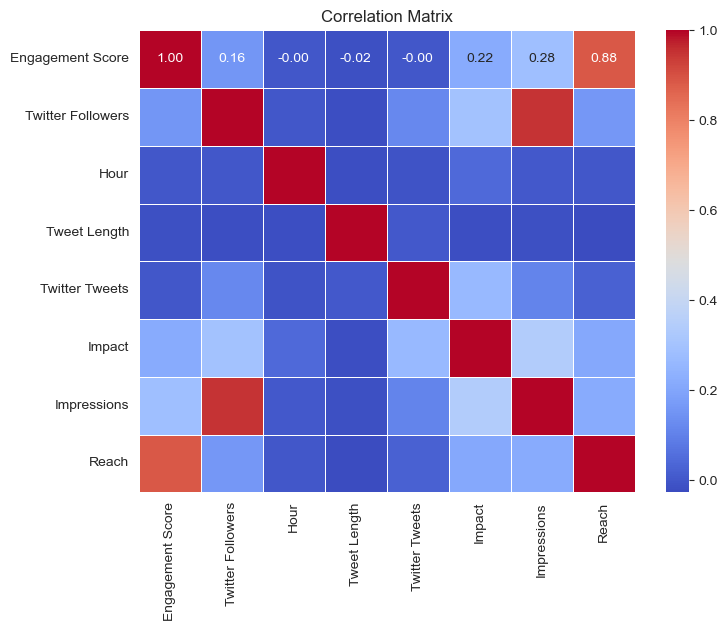

In [86]:
# Correlation matrix
correlation_matrix = df0.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [87]:
# Set dummy variables
for col in ['Sentiment', 'Country Code', 'Gender','Engagement Category', 'Has_Hashtags', 'Account Type' ]:
    datos[col] = datos[col].astype('category')
    datos[col] = datos[col].cat.codes
    datos[col] = datos[col].astype('category')

In [88]:
# Check missing values
missing_values = datos.isna().sum()
print("Variables with missing values:")
print(missing_values[missing_values > 0])


Variables with missing values:
Series([], dtype: int64)


In [89]:
# Portuguese Data
data_pt = datos.loc[datos['Language'] == 'pt']
print("Portugues data: ", data_pt.shape, "\n")

# Spanish Data
data_es = datos.loc[datos['Language'] == 'es']
print("Spanish data: ", data_es.shape, "\n")

# English
data_en = datos.loc[datos['Language'] == 'en']
print("English data: ", data_en.shape, "\n")

Portugues data:  (6056, 17) 

Spanish data:  (2791, 17) 

English data:  (770, 17) 



## Text cleaning

In [90]:
def clean_tweet(tweet, language='en'):
    # Convert all letters to lowercase
    tweet = tweet.lower()
    tweet = re.sub(r'\b(cop)\b', lambda match: match.group(1).upper(), tweet)
    # Removing the twitter usernames from tweet string
    tweet = re.sub(r'@\w+', ' ', tweet)
    # Removing the URLs from the tweet string
    tweet = re.sub(r'http\S+', ' ', tweet)
    # Deleting everything which is not characters
    if language == 'pt':
        tweet = re.sub(r'[^a-zA-ZáéíóúâêîôûãõçüÁÉÍÓÚÂÊÎÔÛÃÕÇÜ]', ' ', tweet)
    elif language == 'es':
        tweet = re.sub(r'[^a-zA-ZáéíóúüÁÉÍÓÚÜ]', ' ', tweet)
    else: # Por defecto, consideramos inglés
        tweet = re.sub(r'[^a-zA-Z]', ' ', tweet)
    # Deleting any word which is less than 3-characters mostly those are stopwords
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Stripping extra spaces in the text
    tweet = re.sub(r' +', ' ', tweet)
    return tweet


In [91]:
data_pt['Tweet_Texts_Cleaned'] = data_pt['Full Text'].apply(lambda x: clean_tweet(x, 'pt'))
data_es['Tweet_Texts_Cleaned'] = data_es['Full Text'].apply(lambda x: clean_tweet(x, 'es'))
data_en['Tweet_Texts_Cleaned'] = data_en['Full Text'].apply(lambda x: clean_tweet(x, 'en'))

In [92]:
# Stopwords elimination
def eliminar_stopwords(texto, language='en'):
    if language == 'pt':
        stop_words = set(stopwords.words('portuguese'))
    elif language == 'es':
        stop_words = set(stopwords.words('spanish'))
    else:
        stop_words = set(stopwords.words('english'))
        
    tokens = word_tokenize(texto)
    tokens_filtrados = [word for word in tokens if word.lower() not in stop_words]
    texto_sin_stopwords = ' '.join(tokens_filtrados)
    return texto_sin_stopwords

In [93]:
data_pt['Full Text Without Stopwords'] = data_pt['Tweet_Texts_Cleaned'].apply(eliminar_stopwords)
data_es['Full Text Without Stopwords'] = data_es['Tweet_Texts_Cleaned'].apply(eliminar_stopwords)
data_en['Full Text Without Stopwords'] = data_en['Tweet_Texts_Cleaned'].apply(eliminar_stopwords)


In [94]:
#remove emojis
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)  

def remove_emoji(string):
    return emoji_pattern.sub(r'', string)

data_pt['tweet_final'] = data_pt['Full Text Without Stopwords'].apply(remove_emoji)
data_es['tweet_final'] = data_es['Full Text Without Stopwords'].apply(remove_emoji)
data_en['tweet_final'] = data_en['Full Text Without Stopwords'].apply(remove_emoji)


## Tokenize tweets

In [95]:
def tokenize_tweet(texto, language='en'):
    if language == 'pt':
        # Descargar los recursos necesarios para tokenizar en portugués (esto solo necesitas hacerlo una vez)
        nltk.download('punkt', quiet=True, raise_on_error=True, download_dir='/tmp')
    elif language == 'es':
        # Descargar los recursos necesarios para tokenizar en español (esto solo necesitas hacerlo una vez)
        nltk.download('punkt', quiet=True, raise_on_error=True, download_dir='/tmp')
    else:
        # Descargar los recursos necesarios para tokenizar en inglés (esto solo necesitas hacerlo una vez)
        nltk.download('punkt', quiet=True, raise_on_error=True, download_dir='/tmp')
        
    # Tokenizar el texto usando la tokenización de palabras de NLTK
    tokens = word_tokenize(texto)
    return tokens

In [96]:
data_pt['Tweet_Tokenized'] = data_pt['tweet_final'].apply(tokenize_tweet)
data_es['Tweet_Tokenized'] = data_es['tweet_final'].apply(tokenize_tweet)
data_en['Tweet_Tokenized'] = data_en['tweet_final'].apply(tokenize_tweet)

# Example
print(data_pt['Tweet_Tokenized'].head())

2327    [que, discurso, falso, lula, fez, COP, dubai, ...
2328    [cop, lula, afirma, ter, reduzido, drasticamen...
2329    [abertura, COP, presidente, ecoa, urgência, en...
2330    [mundo, precisa, conhecer, adotar, soluções, s...
2331    [que, nos, resta, porque, este, planeta, aqui,...
Name: Tweet_Tokenized, dtype: object


# Relevant Topics in Portuguese Data

In [97]:
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Word dictionary
dictionary_pt = Dictionary(data_pt['Tweet_Tokenized'])

# Filter less common words
dictionary_pt.filter_extremes(no_below=5, no_above=0.5)

# Document corpus
corpus_pt = [dictionary_pt.doc2bow(tokens) for tokens in data_pt['Tweet_Tokenized']]

# LDA model
lda_model_pt = LdaModel(corpus_pt, num_topics=4, id2word=dictionary_pt, passes=10)

# Topics
print("Topics in portuguese language:")
for idx, topic in lda_model_pt.print_topics():
    print(f'Topic {idx}: {topic}')

# Obtain the probabilities of belonging to each topic for each tweet
topic_probabilities_pt = lda_model_pt.get_document_topics(corpus_pt)

# Create new columns in the DataFrame to store the probabilities of belonging to each topic
num_topics_pt = lda_model_pt.num_topics
for i in range(num_topics_pt):
    probabilities_pt = [0.0] * len(data_pt) 
    for j, topic_probs in enumerate(topic_probabilities_pt):
        if len(topic_probs) > i:
            probabilities_pt[j] = topic_probs[i][1]
    data_pt[f'Topic_{i}_Probability'] = probabilities_pt


Topics in portuguese language:
Topic 0: 0.039*"COP" + 0.033*"das" + 0.023*"com" + 0.022*"dubai" + 0.019*"brasil" + 0.014*"até" + 0.013*"mulheres" + 0.013*"impacto" + 0.013*"sobre" + 0.013*"horário"
Topic 1: 0.033*"conferência" + 0.032*"sobre" + 0.031*"lula" + 0.028*"presidente" + 0.023*"nações" + 0.020*"clima" + 0.020*"unidas" + 0.020*"desmatamento" + 0.018*"das" + 0.018*"mudança"
Topic 2: 0.061*"lula" + 0.034*"milhões" + 0.032*"com" + 0.032*"COP" + 0.029*"países" + 0.029*"das" + 0.028*"armas" + 0.028*"social" + 0.028*"desigualdade" + 0.027*"veja"
Topic 3: 0.033*"para" + 0.030*"das" + 0.026*"mais" + 0.024*"países" + 0.024*"dubai" + 0.023*"COP" + 0.022*"clima" + 0.021*"representantes" + 0.020*"conferência" + 0.018*"mudança"


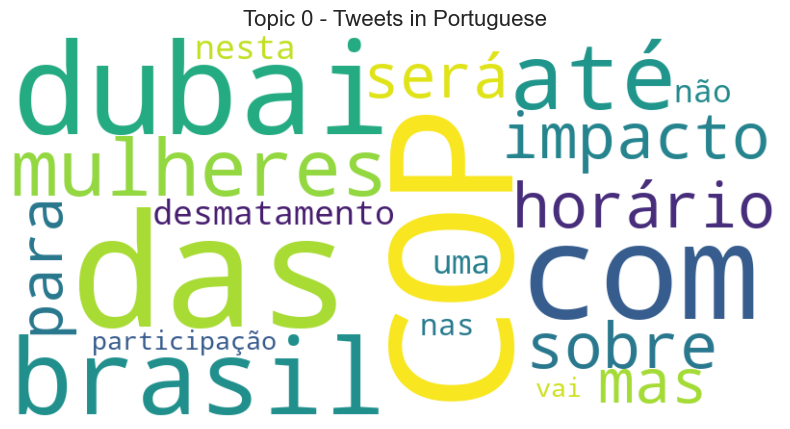

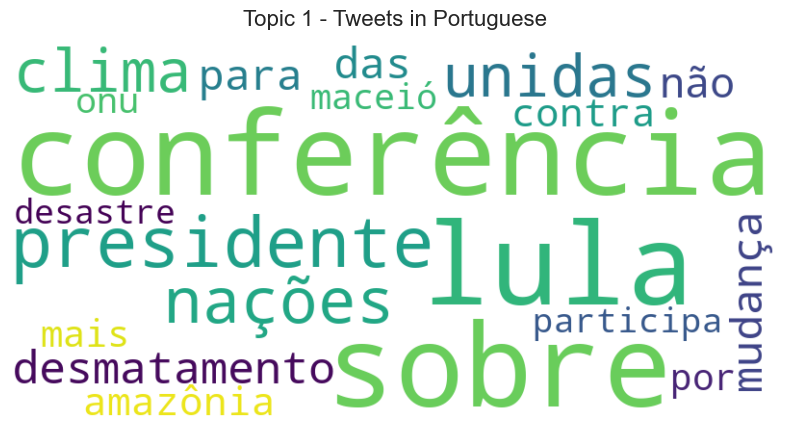

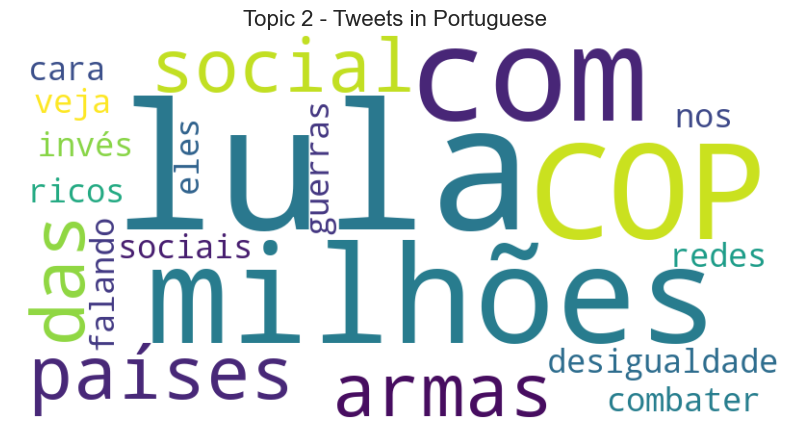

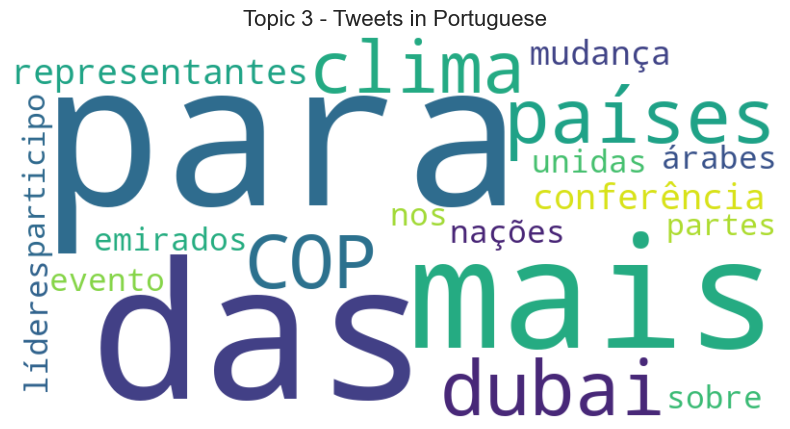

In [98]:
from wordcloud import WordCloud

def create_wordcloud(lda_model, topic_num, language):
    words = dict(lda_model.show_topic(topic_num, topn=20))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic {topic_num} - Tweets in {language}', fontsize=16)
    plt.axis('off')
    plt.show()

for i in range(4):
    create_wordcloud(lda_model_pt, i, 'Portuguese')


## Hashtag Analisis

In [99]:
data_pt['tweet'] = data_pt['Full Text']

def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

# make new columns for retweeted usernames, mentioned usernames and hashtags
data_pt['retweeted'] = data_pt.tweet.apply(find_retweeted)
data_pt['mentioned'] = data_pt.tweet.apply(find_mentioned)
data_pt['hashtags'] = data_pt.tweet.apply(find_hashtags)

In [100]:
# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = data_pt.loc[
                       data_pt.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]

flattened_hashtags_df = pd.DataFrame(
    [hashtag.lower() for hashtags_list in hashtags_list_df['hashtags']
     for hashtag in hashtags_list],
    columns=['hashtag'])

# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size().reset_index(name='counts').sort_values('counts', ascending=False).reset_index(drop=True)

In [101]:
# Average Engagement Score by Author
engagement_score_por_autor = data_pt.groupby('Author')['Engagement Score'].mean().reset_index()
engagement_score_por_autor_sorted = engagement_score_por_autor.sort_values(by='Engagement Score', ascending=False)

# Average tweet length por autor
tweet_length_por_autor = data_pt.groupby('Author')['Tweet Length'].mean().reset_index()
engagement_score_y_length = pd.merge(engagement_score_por_autor_sorted, tweet_length_por_autor, on='Author')

print(engagement_score_y_length)

              Author  Engagement Score  Tweet Length
0       revistaoeste           13848.0    101.000000
1          JanjaLula            5118.5    225.000000
2        MarinaSilva            5040.5    265.000000
3        LulaOficial            4723.0    231.666667
4        UOLNoticias            3245.5    233.000000
...              ...               ...           ...
3499    MonicaDiario               0.0    319.000000
3500    Monicafg1302               0.0    314.000000
3501  MonikePaivaTel               0.0    272.000000
3502      MoraesPT13               0.0    294.500000
3503     zunzequinha               0.0    288.000000

[3504 rows x 3 columns]


# Relevant Topics in English Data

In [102]:
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Word Dictionary
dictionary_en = Dictionary(data_en['Tweet_Tokenized'])

# Filter less common words
dictionary_en.filter_extremes(no_below=5, no_above=0.5)

# Document corpus
corpus_en = [dictionary_en.doc2bow(tokens) for tokens in data_en['Tweet_Tokenized']]

# LDA model
lda_model_en = LdaModel(corpus_en, num_topics=4, id2word=dictionary_en, passes=10)

# Topics
print("Topics in English language:")
for idx, topic in lda_model_en.print_topics():
    print(f'Topic {idx}: {topic}')

# Obtain the probabilities of belonging to each topic for each tweet
topic_probabilities_en = lda_model_en.get_document_topics(corpus_en)

# Create new columns in the DataFrame to store the probabilities of belonging to each topic
num_topics_en = lda_model_en.num_topics
for i in range(num_topics_en):
    probabilities_en = [0.0] * len(data_en)  
    for j, topic_probs in enumerate(topic_probabilities_en):
        if len(topic_probs) > i:
            probabilities_en[j] = topic_probs[i][1]
    data_en[f'Topic_{i}_Probability'] = probabilities_en


Topics in English language:
Topic 0: 0.026*"dubai" + 0.024*"summit" + 0.023*"world" + 0.022*"leaders" + 0.022*"climatechange" + 0.021*"today" + 0.015*"conference" + 0.014*"united" + 0.014*"would" + 0.013*"gather"
Topic 1: 0.025*"take" + 0.022*"people" + 0.021*"world" + 0.018*"time" + 0.018*"year" + 0.016*"action" + 0.015*"global" + 0.015*"act" + 0.013*"historic" + 0.013*"responsibility"
Topic 2: 0.026*"fund" + 0.023*"dubai" + 0.020*"damage" + 0.017*"new" + 0.016*"conference" + 0.016*"loss" + 0.015*"world" + 0.015*"leaders" + 0.015*"global" + 0.013*"action"
Topic 3: 0.036*"climatechange" + 0.018*"carbon" + 0.016*"world" + 0.015*"uae" + 0.012*"finance" + 0.011*"leaders" + 0.010*"key" + 0.010*"science" + 0.010*"countries" + 0.009*"global"


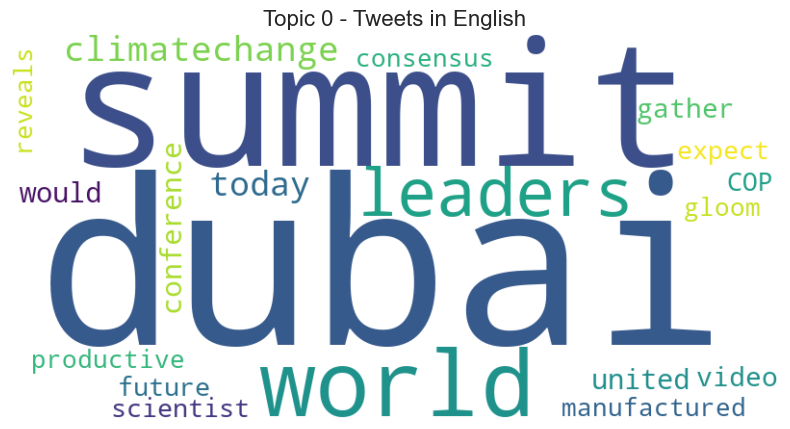

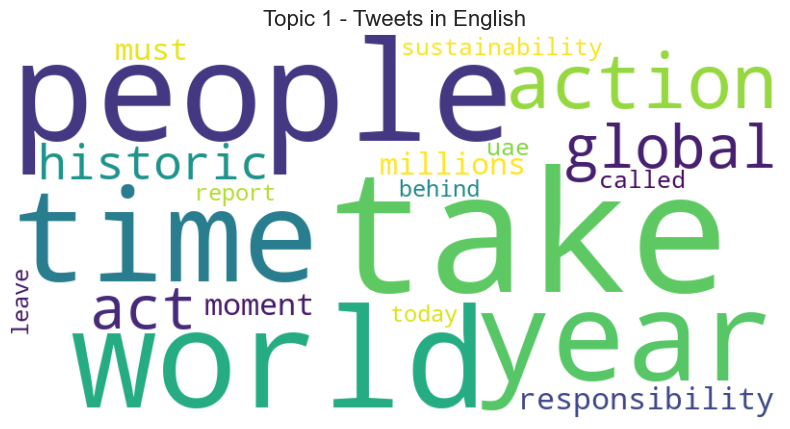

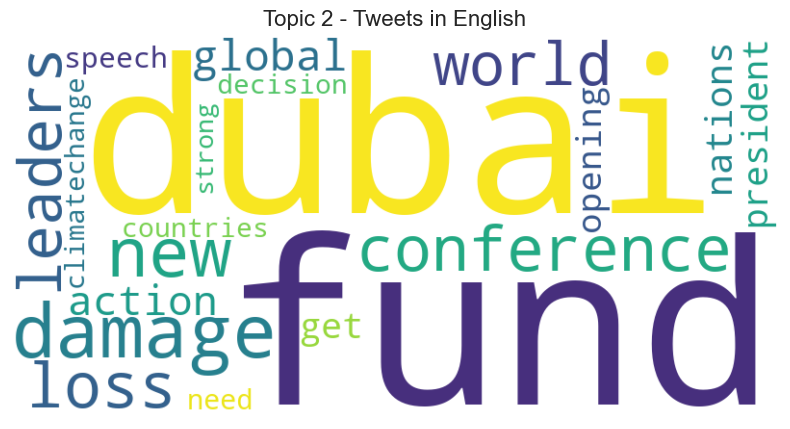

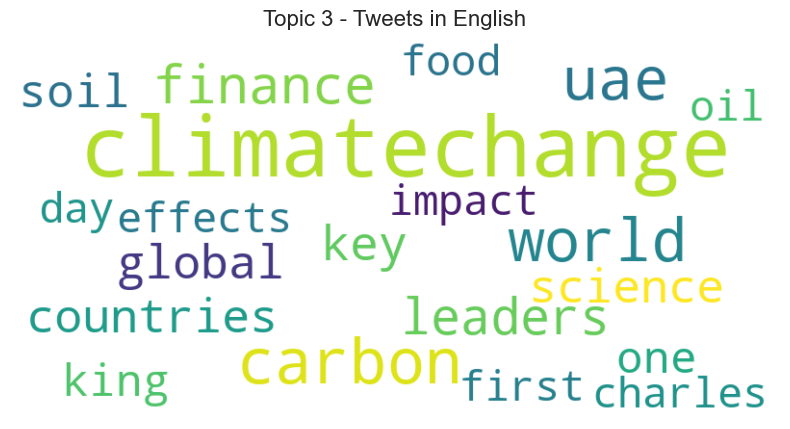

In [103]:
# Crear nubes de palabras para los temas en inglés
for i in range(4):
    create_wordcloud(lda_model_en, i, 'English')


In [104]:
data_en['tweet'] = data_en['Full Text']
# make new columns for retweeted usernames, mentioned usernames and hashtags
data_en['retweeted'] = data_en.tweet.apply(find_retweeted)
data_en['mentioned'] = data_en.tweet.apply(find_mentioned)
data_en['hashtags'] = data_en.tweet.apply(find_hashtags)

# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = data_en.loc[
                       data_en.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]

flattened_hashtags_df = pd.DataFrame(
    [hashtag.lower() for hashtags_list in hashtags_list_df['hashtags']
     for hashtag in hashtags_list],
    columns=['hashtag'])

# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size().reset_index(name='counts').sort_values('counts', ascending=False).reset_index(drop=True)

# Average Engagement Score by Author
engagement_score_por_autor = data_en.groupby('Author')['Engagement Score'].mean().reset_index()
engagement_score_por_autor_sorted = engagement_score_por_autor.sort_values(by='Engagement Score', ascending=False)

# Average tweet length por autor
tweet_length_por_autor = data_en.groupby('Author')['Tweet Length'].mean().reset_index()
engagement_score_y_length = pd.merge(engagement_score_por_autor_sorted, tweet_length_por_autor, on='Author')

print(engagement_score_y_length)


              Author  Engagement Score  Tweet Length
0            IMFNews            1122.0         298.0
1            rajshah            1077.0         280.0
2              ZLabe             426.0         162.0
3    MatthewWielicki             257.0         250.5
4            nytimes             232.0         238.0
..               ...               ...           ...
704    LorettaBower3               0.0         292.0
705  LuciaCa83596362               0.0         292.0
706       MABizCoach               0.0         296.0
707       MMahoneyDC               0.0         192.0
708        zukszoo72               0.0         296.0

[709 rows x 3 columns]


# Relevant Topics in Spanish Data

In [105]:
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Word dictionary
dictionary_es = Dictionary(data_es['Tweet_Tokenized'])

# Filter less common words
dictionary_es.filter_extremes(no_below=4, no_above=0.5)

# Document corpus
corpus_es = [dictionary_es.doc2bow(tokens) for tokens in data_es['Tweet_Tokenized']]

# LDA model
lda_model_es = LdaModel(corpus_es, num_topics=4, id2word=dictionary_es, passes=10)

# Topics
print("Topics in Spanish:")
for idx, topic in lda_model_es.print_topics():
    print(f'Topic {idx}: {topic}')

# Obtain the probabilities of belonging to each topic for each tweet
topic_probabilities_es = lda_model_es.get_document_topics(corpus_es)

# Create new columns in the DataFrame to store the probabilities of belonging to each topica
num_topics_es = lda_model_es.num_topics
for i in range(num_topics_es):
    probabilities_es = [0.0] * len(data_es)
    for j, topic_probs in enumerate(topic_probabilities_es):
        if len(topic_probs) > i:
            probabilities_es[j] = topic_probs[i][1]
    data_es[f'Topic_{i}_Probability'] = probabilities_es


Topics in Spanish:
Topic 0: 0.074*"del" + 0.031*"las" + 0.024*"edificio" + 0.022*"dubái" + 0.021*"más" + 0.020*"que" + 0.018*"colombia" + 0.017*"como" + 0.016*"país" + 0.016*"cambio"
Topic 1: 0.040*"cambio" + 0.032*"climático" + 0.028*"las" + 0.027*"del" + 0.026*"para" + 0.019*"climática" + 0.018*"sobre" + 0.017*"conferencia" + 0.016*"con" + 0.015*"los"
Topic 2: 0.043*"para" + 0.026*"climática" + 0.024*"colombia" + 0.023*"del" + 0.022*"con" + 0.020*"dubai" + 0.018*"acción" + 0.017*"petro" + 0.016*"energética" + 0.015*"por"
Topic 3: 0.033*"climática" + 0.032*"que" + 0.027*"para" + 0.026*"crisis" + 0.025*"por" + 0.022*"climático" + 0.022*"cambio" + 0.019*"cumbre" + 0.019*"mundial" + 0.018*"los"


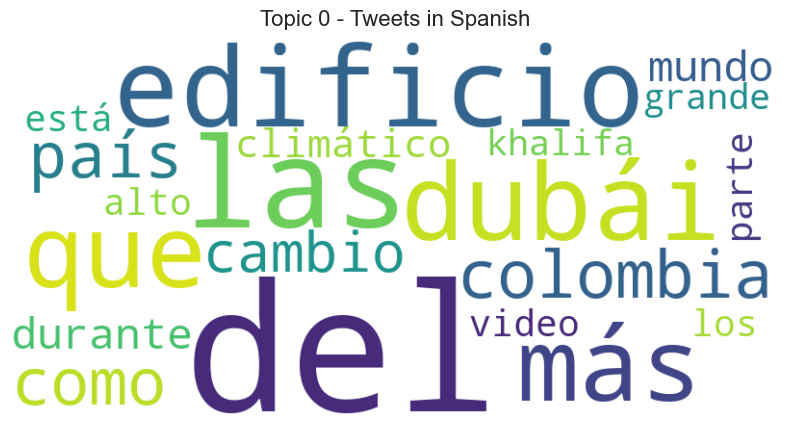

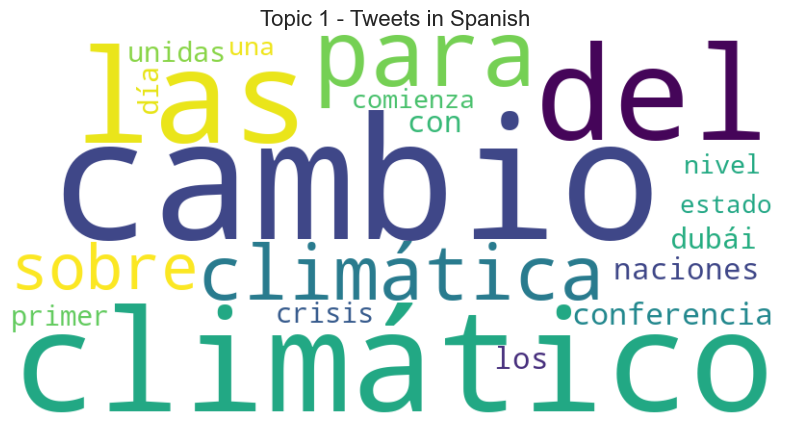

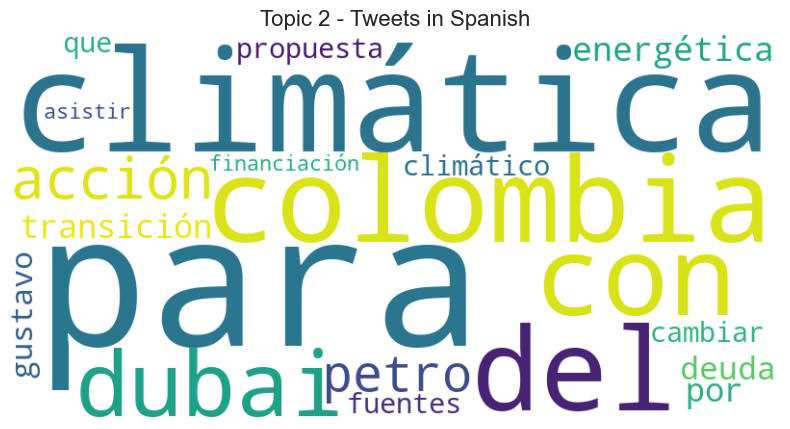

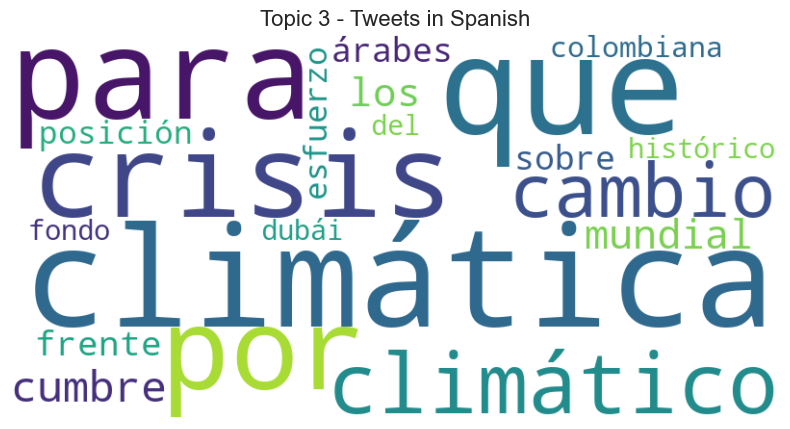

In [106]:
# Crear nubes de palabras para los temas en español
for i in range(4):
    create_wordcloud(lda_model_es, i, 'Spanish')

In [107]:
data_es['tweet'] = data_es['Full Text']
# make new columns for retweeted usernames, mentioned usernames and hashtags
data_es['retweeted'] = data_es.tweet.apply(find_retweeted)
data_es['mentioned'] = data_es.tweet.apply(find_mentioned)
data_es['hashtags'] = data_es.tweet.apply(find_hashtags)

# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = data_es.loc[
                       data_es.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]

flattened_hashtags_df = pd.DataFrame(
    [hashtag.lower() for hashtags_list in hashtags_list_df['hashtags']
     for hashtag in hashtags_list],
    columns=['hashtag'])

# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size().reset_index(name='counts').sort_values('counts', ascending=False).reset_index(drop=True)

# Average Engagement Score by Author
engagement_score_por_autor = data_es.groupby('Author')['Engagement Score'].mean().reset_index()
engagement_score_por_autor_sorted = engagement_score_por_autor.sort_values(by='Engagement Score', ascending=False)

# Average tweet length por autor
tweet_length_por_autor = data_es.groupby('Author')['Tweet Length'].mean().reset_index()
engagement_score_y_length = pd.merge(engagement_score_por_autor_sorted, tweet_length_por_autor, on='Author')

print(engagement_score_y_length)


               Author  Engagement Score  Tweet Length
0      FelipeCalderon       5278.000000        275.00
1       HOLLMANMORRIS       4382.000000        209.00
2        RTVCnoticias       1538.250000        271.75
3     infopresidencia        488.166667        287.00
4              makugo        481.000000        300.00
...               ...               ...           ...
1950    Mario95901733          0.000000        271.00
1951   Marielarubiano          0.000000        207.00
1952    MarielaAlvear          0.000000        185.00
1953       Mariape_28          0.000000        314.00
1954           _lise6          0.000000        301.00

[1955 rows x 3 columns]


# Tweet Engagement - Portuguese Language

In [154]:
y = data_pt['Engagement Category'].ravel()
columnas_a_eliminar = ['Engagement Category', 'Language', 'Author', 'Engagement Score' ,'Full Text', 'Tweet_Texts_Cleaned', 'Full Text Without Stopwords', 'tweet_final', 'Tweet_Tokenized', 'tweet', 'retweeted',	'mentioned',	'hashtags']
X = data_pt.loc[:, ~data_pt.columns.isin(columnas_a_eliminar)]
# Data final
columnas_a_eliminar = ['Language', 'Author', 'Engagement Score' ,'Full Text', 'Tweet_Texts_Cleaned', 'Full Text Without Stopwords', 'tweet_final', 'Tweet_Tokenized', 'tweet', 'retweeted',	'mentioned',	'hashtags']
datos = data_pt.loc[:, ~data_pt.columns.isin(columnas_a_eliminar)]

In [155]:
print("Data COP28 (Portuguese Language): ", datos.shape, "\n")

Data COP28 (Portuguese Language):  (6056, 17) 



In [156]:
#Training-Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80 )

## Decision Tree

Métricas Arbol:
Precisión Global: 0.966996699669967
Error Global: 0.03300330033003296
Precisión Positiva: 0.7032967032967034
Precisión Negativa: 0.9884032114183765


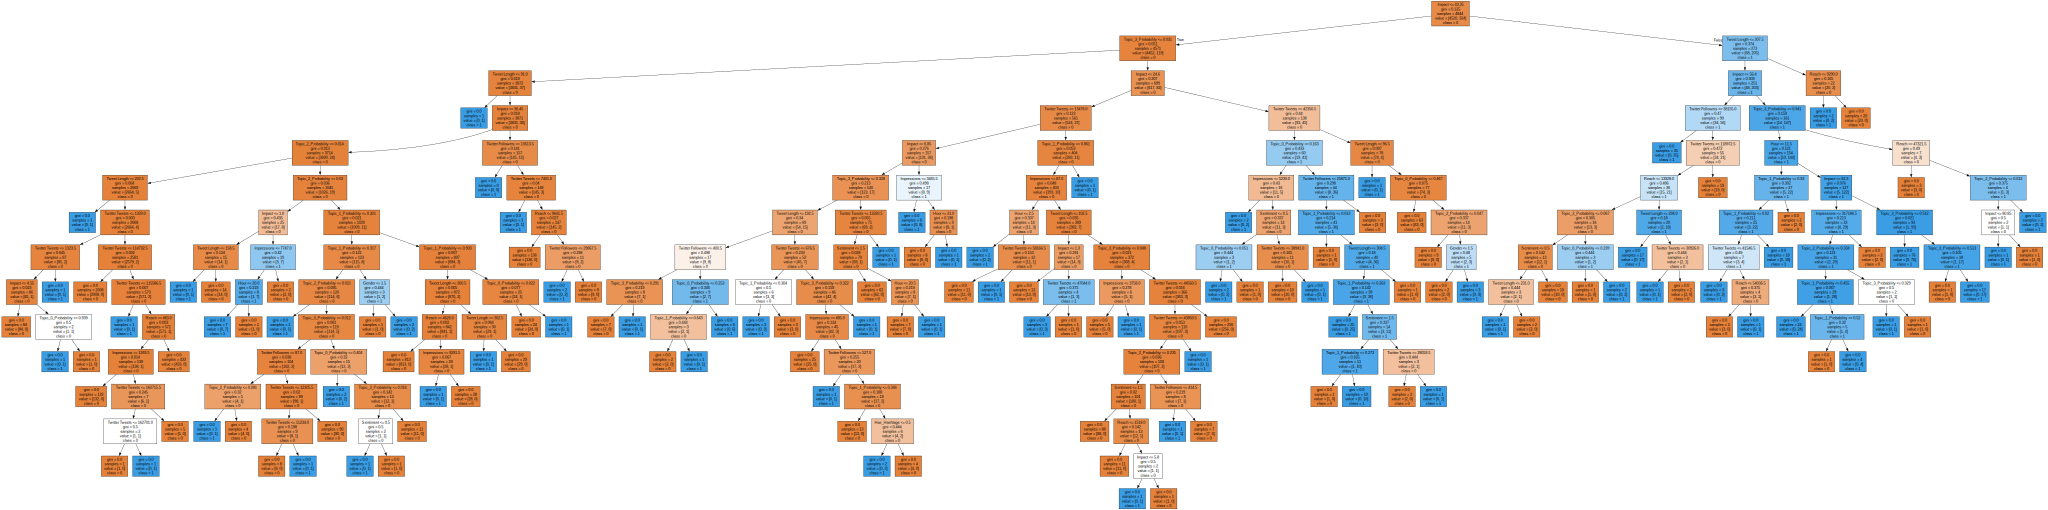

In [157]:
instancia_arbol = DecisionTreeClassifier()
instancia_arbol.fit(X_train,y_train)
prediccion = instancia_arbol.predict(X_test)
MC_arbol = confusion_matrix(y_test, prediccion)

MC_arbol = MC_arbol.ravel()
MC_arbol

calculator_arbol = MetricsCalculator(MC_arbol)
metrics_arbol = calculator_arbol.calculate_metrics()

print("Métricas Arbol:")
for metric, value in metrics_arbol.items():
    print(f"{metric}: {value}")

from sklearn.tree import export_graphviz
datos_plotear = export_graphviz(instancia_arbol, out_file=None,class_names=["0", "1"],
                feature_names=list(X.columns.values), filled=True)
grafico = graphviz.Source(datos_plotear, filename="arbol_booking", format="png") 
grafico.view()
grafico

## KNN

In [158]:
instancia_knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
instancia_knn.fit(X_train.values, y_train)
prediccion_knn = instancia_knn.predict(X_test.values)

MC_knn = confusion_matrix(y_test, prediccion_knn)
MC_knn = MC_knn.ravel()

calculator_knn = MetricsCalculator(MC_knn)
metrics_knn = calculator_knn.calculate_metrics()

print("Métricas Knn:")
for metric, value in metrics_knn.items():
    print(f"{metric}: {value}")

Métricas Knn:
Precisión Global: 0.9504950495049505
Error Global: 0.04950495049504955
Precisión Positiva: 0.5274725274725275
Precisión Negativa: 0.9848349687778769


## Random Forest

In [159]:
instancia_bosques = RandomForestClassifier(n_estimators = 155, criterion = "gini", min_samples_split = 2)

analisis_tweet = Analisis_Predictivo(datos,
                                       predecir = 'Engagement Category',
                                       modelo   = instancia_bosques,
                                       train_size = 0.80)
# Model selection
resultados = analisis_tweet.fit_predict_resultados()

matriz_confusion = resultados['Matriz de Confusión']
TP = matriz_confusion[0][0]
FP = matriz_confusion[0][1]
FN = matriz_confusion[1][0]
TN = matriz_confusion[1][1]
MC_rf = [TP, FP, FN, TN]

# Metrics
calculator_rf = MetricsCalculator(MC_rf)
metrics_rf = calculator_rf.calculate_metrics()

print("Métricas Random Forest:")
for metric, value in metrics_rf.items():
    print(f"{metric}: {value}")


Matriz de Confusión:
[[1126    8]
 [  20   58]]

Precisión Global:
0.976897689768977

Error Global:
0.02310231023102305

Precisión por categoría:
          0        1
0  0.992945  0.74359
Métricas Random Forest:
Precisión Global: 0.976897689768977
Error Global: 0.02310231023102305
Precisión Positiva: 0.7435897435897436
Precisión Negativa: 0.9929453262786596


## ADABoosting

In [160]:
instancia_rf = RandomForestClassifier(min_samples_split = 17)

instancia_ada = AdaBoostClassifier(base_estimator = instancia_rf,
                                   n_estimators   = 170)

analisis_tweet2 = Analisis_Predictivo(datos, 
                                       predecir = "Engagement Category", 
                                       modelo   = instancia_ada,
                                       estandarizar = True,
                                       train_size   = 0.8)
# Model evaluation
resultados2 = analisis_tweet2.fit_predict_resultados()
matriz_confusion = resultados2['Matriz de Confusión']
TP = matriz_confusion[0][0]
FP = matriz_confusion[0][1]
FN = matriz_confusion[1][0]
TN = matriz_confusion[1][1]
MC_ab = [TP, FP, FN, TN]
# Metrics
calculator_ab = MetricsCalculator(MC_ab)
metrics_ab = calculator_ab.calculate_metrics()

print("Métricas Ada boosting:")
for metric, value in metrics_ab.items():
    print(f"{metric}: {value}")



Matriz de Confusión:
[[1134    7]
 [  14   57]]

Precisión Global:
0.9826732673267327

Error Global:
0.017326732673267342

Precisión por categoría:
          0         1
0  0.993865  0.802817
Métricas Ada boosting:
Precisión Global: 0.9826732673267327
Error Global: 0.017326732673267342
Precisión Positiva: 0.8028169014084507
Precisión Negativa: 0.9938650306748467


## XGBoosting

In [161]:
instancia_gbc = GradientBoostingClassifier(n_estimators = 300, min_samples_split = 7)

analisis_tweet3 = Analisis_Predictivo(datos, 
                                       predecir = "Engagement Category", 
                                       modelo = instancia_gbc, 
                                       train_size = 0.8)
# Model selection
resultados3 = analisis_tweet3.fit_predict_resultados()
matriz_confusion = resultados3['Matriz de Confusión']
TP = matriz_confusion[0][0]
FP = matriz_confusion[0][1]
FN = matriz_confusion[1][0]
TN = matriz_confusion[1][1]
MC_xg = [TP, FP, FN, TN]
# Metricas
calculator_xg = MetricsCalculator(MC_xg)
metrics_xg = calculator_xg.calculate_metrics()

print("Métricas XG boosting:")
for metric, value in metrics_xg.items():
    print(f"{metric}: {value}")


Matriz de Confusión:
[[1119    7]
 [  19   67]]

Precisión Global:
0.9785478547854786

Error Global:
0.021452145214521434

Precisión por categoría:
          0        1
0  0.993783  0.77907
Métricas XG boosting:
Precisión Global: 0.9785478547854786
Error Global: 0.021452145214521434
Precisión Positiva: 0.7790697674418605
Precisión Negativa: 0.9937833037300178


In [219]:
data = {
    'Predictive Model': ['KNN', 'Decision Tree', 'Random Forest', 'Ada Boosting', 'XGBoosting'],
    'Global Precision': [metrics_knn['Precisión Global'], metrics_arbol['Precisión Global'], metrics_rf['Precisión Global'], metrics_ab['Precisión Global'], metrics_xg['Precisión Global']],
    'Overall Error': [metrics_knn['Error Global'], metrics_arbol['Error Global'], metrics_rf['Error Global'], metrics_ab['Error Global'], metrics_xg['Error Global']],
    'Positive Precision': [metrics_knn['Precisión Positiva'], metrics_arbol['Precisión Positiva'], metrics_rf['Precisión Positiva'], metrics_ab['Precisión Positiva'], metrics_xg['Precisión Positiva']],
    'Negative Precision': [metrics_knn['Precisión Negativa'], metrics_arbol['Precisión Negativa'], metrics_rf['Precisión Negativa'], metrics_ab['Precisión Negativa'], metrics_xg['Precisión Negativa']]
}

# DataFrame
comparacion_modelos = pd.DataFrame(data)
comparacion_modelos.style.set_caption("<b>Model Comparison - Portugues Language</b>")

,Predictive Model,Global Precision,Overall Error,Positive Precision,Negative Precision
0,KNN,0.889610,0.110390,0.437500,0.942029
1,Decision Tree,0.889610,0.110390,0.500000,0.934783
2,Random Forest,0.922078,0.077922,0.571429,0.977444
3,Ada Boosting,0.902597,0.097403,0.629630,0.960630
4,XGBoosting,0.941558,0.058442,0.826087,0.961832


##  Variable importance of the best model

In [163]:
importancia = np.array(analisis_tweet3.modelo.feature_importances_)
etiquetas   = np.array(analisis_tweet3.predictoras)

#Order
orden       = np.argsort(importancia)
importancia = importancia[orden]
etiquetas   = etiquetas[orden]

print("Importancia de las variables: ",importancia, "\n")

Importancia de las variables:  [0.00000000e+00 1.53736030e-04 5.66841178e-04 8.84798386e-04
 1.50092074e-03 6.18791357e-03 1.93998831e-02 2.34809615e-02
 3.02595512e-02 3.08921440e-02 4.27370985e-02 5.19715058e-02
 6.04492214e-02 6.40033887e-02 1.10411228e-01 5.57100808e-01] 



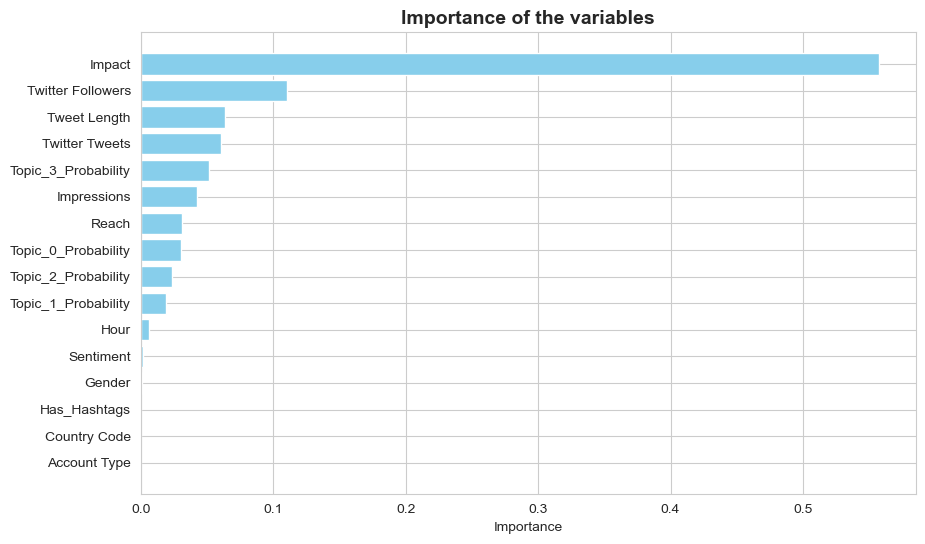

In [164]:
etiquetas_importancia_sorted = [x for _,x in sorted(zip(importancia, etiquetas))]
importancia_sorted = sorted(importancia)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(etiquetas_importancia_sorted, importancia_sorted, color='skyblue')

ax.set_xlabel('Importance')
ax.set_title('Importance of the variables', fontsize=14, fontweight='bold')

plt.show()

# Tweet Engagement - Spanish Language

In [310]:
y = data_es['Engagement Category'].ravel()
columnas_a_eliminar = ['Engagement Category', 'Language', 'Author', 'Engagement Score' ,'Full Text', 'Tweet_Texts_Cleaned', 'Full Text Without Stopwords', 'tweet_final', 'Tweet_Tokenized', 'tweet', 'retweeted',	'mentioned',	'hashtags']
X = data_es.loc[:, ~data_es.columns.isin(columnas_a_eliminar)]
# Data final
columnas_a_eliminar = ['Language', 'Author', 'Engagement Score' ,'Full Text', 'Tweet_Texts_Cleaned', 'Full Text Without Stopwords', 'tweet_final', 'Tweet_Tokenized', 'tweet', 'retweeted',	'mentioned',	'hashtags']
datos = data_es.loc[:, ~data_es.columns.isin(columnas_a_eliminar)]


In [311]:
print("Data COP28 (Spanish Language): ", datos.shape, "\n")

Data COP28 (Spanish Language):  (2791, 17) 



In [312]:
#Training-Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80 )

## Decision Tree

Métricas Arbol:
Precisión Global: 0.9713774597495528
Error Global: 0.028622540250447193
Precisión Positiva: 0.7857142857142857
Precisión Negativa: 0.9811676082862524


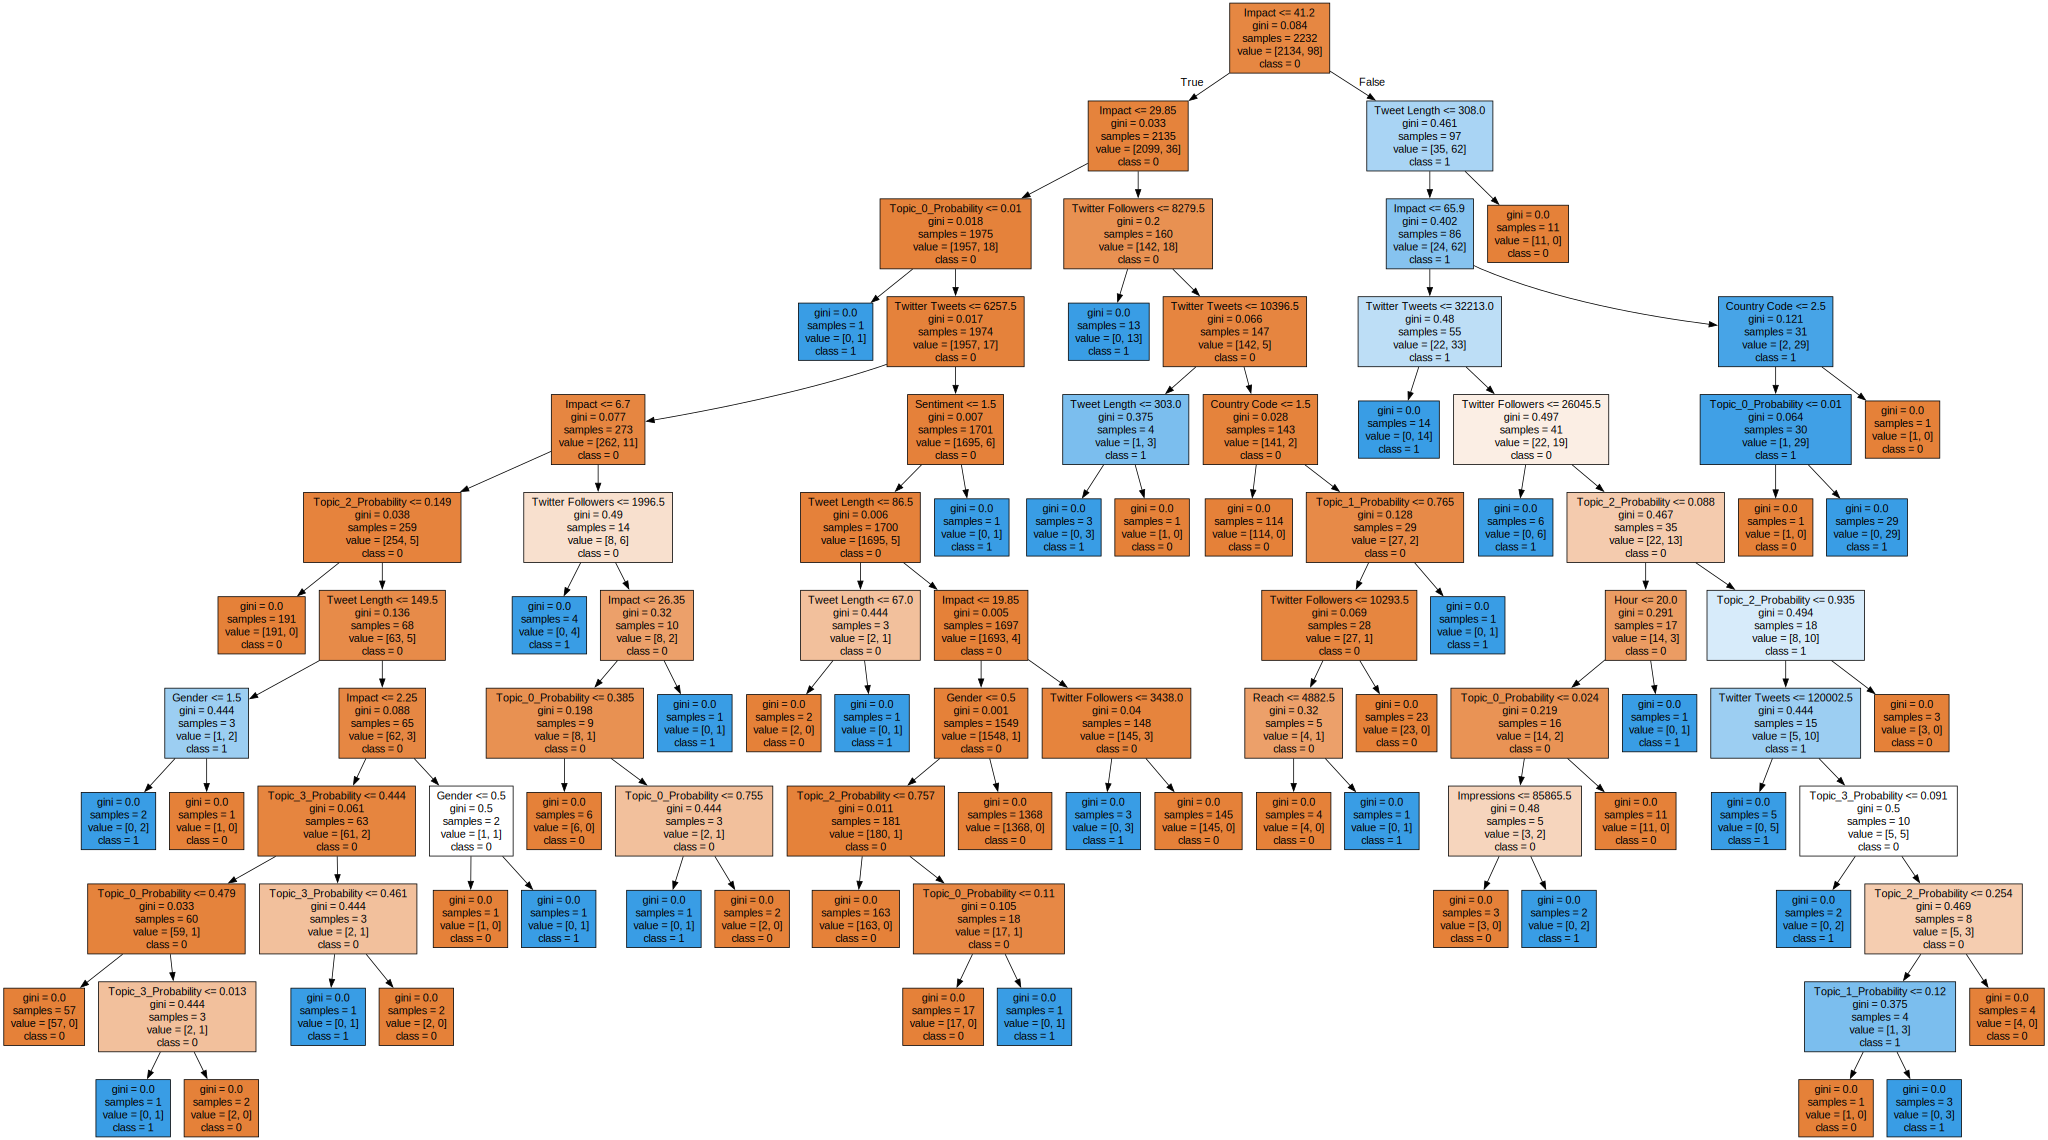

In [313]:
#Genera el modelo, las predicciones y mide la calidad de las mismas
instancia_arbol = DecisionTreeClassifier()
instancia_arbol.fit(X_train,y_train)
prediccion = instancia_arbol.predict(X_test)
MC_arbol = confusion_matrix(y_test, prediccion)

# Calcular la matriz de confusión utilizando las etiquetas verdaderas y las predicciones
MC_arbol = MC_arbol.ravel()
MC_arbol

calculator_arbol = MetricsCalculator(MC_arbol)
metrics_arbol = calculator_arbol.calculate_metrics()

print("Métricas Arbol:")
for metric, value in metrics_arbol.items():
    print(f"{metric}: {value}")

from sklearn.tree import export_graphviz
datos_plotear = export_graphviz(instancia_arbol, out_file=None,class_names=["0", "1"],
                feature_names=list(X.columns.values), filled=True)
grafico = graphviz.Source(datos_plotear, filename="arbol_booking", format="png") 
grafico.view()
grafico

## KNN

In [314]:
# Genera el modelo de KNN
instancia_knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
instancia_knn.fit(X_train.values, y_train)
prediccion_knn = instancia_knn.predict(X_test.values)

# Calcular la matriz de confusión utilizando las etiquetas verdaderas y las predicciones
MC_knn = confusion_matrix(y_test, prediccion_knn)
MC_knn = MC_knn.ravel()

calculator_knn = MetricsCalculator(MC_knn)
metrics_knn = calculator_knn.calculate_metrics()

print("Métricas Knn:")
for metric, value in metrics_knn.items():
    print(f"{metric}: {value}")

Métricas Knn:
Precisión Global: 0.9677996422182469
Error Global: 0.03220035778175312
Precisión Positiva: 0.4642857142857143
Precisión Negativa: 0.9943502824858758


## Random forest

In [315]:
#Construccion del modelo: Bosques Aleatorios
instancia_bosques = RandomForestClassifier(n_estimators = 155, criterion = "gini", min_samples_split = 2)

analisis_tweet = Analisis_Predictivo(datos,
                                       predecir = 'Engagement Category',
                                       modelo   = instancia_bosques,
                                       train_size = 0.80)
#Evaluacion modelo
resultados = analisis_tweet.fit_predict_resultados()

# Matriz de confusion Random Forest
matriz_confusion = resultados['Matriz de Confusión']

# Extraer los valores de la matriz de confusión
TP = matriz_confusion[0][0]
FP = matriz_confusion[0][1]
FN = matriz_confusion[1][0]
TN = matriz_confusion[1][1]
# Crear un vector de 1x4 con los valores extraídos
MC_rf = [TP, FP, FN, TN]
# Metricas
calculator_rf = MetricsCalculator(MC_rf)
metrics_rf = calculator_rf.calculate_metrics()

print("Métricas Random Forest:")
for metric, value in metrics_rf.items():
    print(f"{metric}: {value}")


Matriz de Confusión:
[[536   6]
 [  4  13]]

Precisión Global:
0.9821109123434705

Error Global:
0.017889087656529523

Precisión por categoría:
         0         1
0  0.98893  0.764706
Métricas Random Forest:
Precisión Global: 0.9821109123434705
Error Global: 0.017889087656529523
Precisión Positiva: 0.7647058823529411
Precisión Negativa: 0.988929889298893


## Ada Boosting

In [316]:
# Construcción de modelo
# Instancia Ada Boosting
instancia_rf = RandomForestClassifier(min_samples_split = 17)

instancia_ada = AdaBoostClassifier(base_estimator = instancia_rf,
                                   n_estimators   = 170)

analisis_tweet2 = Analisis_Predictivo(datos, 
                                       predecir = "Engagement Category", 
                                       modelo   = instancia_ada,
                                       estandarizar = True,
                                       train_size   = 0.8)
#Evaluacion modelo
resultados2 = analisis_tweet2.fit_predict_resultados()

# Matriz de confusion Ada Boosting
matriz_confusion = resultados2['Matriz de Confusión']
# Extraer los valores de la matriz de confusión
TP = matriz_confusion[0][0]
FP = matriz_confusion[0][1]
FN = matriz_confusion[1][0]
TN = matriz_confusion[1][1]
# Crear un vector de 1x4 con los valores extraídos
MC_ab = [TP, FP, FN, TN]
# Metricas
calculator_ab = MetricsCalculator(MC_ab)
metrics_ab = calculator_ab.calculate_metrics()

print("Métricas Ada boosting:")
for metric, value in metrics_ab.items():
    print(f"{metric}: {value}")


Matriz de Confusión:
[[531   4]
 [ 13  11]]

Precisión Global:
0.9695885509838998

Error Global:
0.030411449016100156

Precisión por categoría:
          0         1
0  0.992523  0.458333
Métricas Ada boosting:
Precisión Global: 0.9695885509838998
Error Global: 0.030411449016100156
Precisión Positiva: 0.4583333333333333
Precisión Negativa: 0.9925233644859813


## XG Boosting

In [317]:
#Construcción de modelo
instancia_gbc = GradientBoostingClassifier(n_estimators = 300, min_samples_split = 7)

analisis_tweet3 = Analisis_Predictivo(datos, 
                                       predecir = "Engagement Category", 
                                       modelo = instancia_gbc, 
                                       train_size = 0.8)
#Evaluacion modelo
resultados3 = analisis_tweet3.fit_predict_resultados()

# Matriz de confusion XGBoosting
matriz_confusion = resultados3['Matriz de Confusión']
# Extraer los valores de la matriz de confusión
TP = matriz_confusion[0][0]
FP = matriz_confusion[0][1]
FN = matriz_confusion[1][0]
TN = matriz_confusion[1][1]
# Crear un vector de 1x4 con los valores extraídos
MC_xg = [TP, FP, FN, TN]
# Metricas
calculator_xg = MetricsCalculator(MC_xg)
metrics_xg = calculator_xg.calculate_metrics()

print("Métricas XG boosting:")
for metric, value in metrics_xg.items():
    print(f"{metric}: {value}")


Matriz de Confusión:
[[530   5]
 [  8  16]]

Precisión Global:
0.9767441860465116

Error Global:
0.023255813953488413

Precisión por categoría:
          0         1
0  0.990654  0.666667
Métricas XG boosting:
Precisión Global: 0.9767441860465116
Error Global: 0.023255813953488413
Precisión Positiva: 0.6666666666666666
Precisión Negativa: 0.9906542056074766


In [318]:
data = {
    'Predictive Model': ['KNN', 'Decision Tree', 'Random Forest', 'Ada Boosting', 'XGBoosting'],
    'Global Precision': [metrics_knn['Precisión Global'], metrics_arbol['Precisión Global'], metrics_rf['Precisión Global'], metrics_ab['Precisión Global'], metrics_xg['Precisión Global']],
    'Overall Error': [metrics_knn['Error Global'], metrics_arbol['Error Global'], metrics_rf['Error Global'], metrics_ab['Error Global'], metrics_xg['Error Global']],
    'Positive Precision': [metrics_knn['Precisión Positiva'], metrics_arbol['Precisión Positiva'], metrics_rf['Precisión Positiva'], metrics_ab['Precisión Positiva'], metrics_xg['Precisión Positiva']],
    'Negative Precision': [metrics_knn['Precisión Negativa'], metrics_arbol['Precisión Negativa'], metrics_rf['Precisión Negativa'], metrics_ab['Precisión Negativa'], metrics_xg['Precisión Negativa']]
}

# DataFrame
comparacion_modelos = pd.DataFrame(data)
comparacion_modelos.style.set_caption("<b>Model Comparison - Spanish Language</b>")

,Predictive Model,Global Precision,Overall Error,Positive Precision,Negative Precision
0,KNN,0.967800,0.032200,0.464286,0.994350
1,Decision Tree,0.971377,0.028623,0.785714,0.981168
2,Random Forest,0.982111,0.017889,0.764706,0.988930
3,Ada Boosting,0.969589,0.030411,0.458333,0.992523
4,XGBoosting,0.976744,0.023256,0.666667,0.990654


## Variable importance of the best model

In [319]:
#Obtenemos valores
importancia = np.array(analisis_tweet.modelo.feature_importances_)
etiquetas   = np.array(analisis_tweet.predictoras)

#Ordenar
orden       = np.argsort(importancia)
importancia = importancia[orden]
etiquetas   = etiquetas[orden]

print("Importancia de las variables: ",importancia, "\n")

Importancia de las variables:  [0.00000000e+00 2.72808238e-04 1.10876387e-03 1.25008142e-03
 9.16179761e-03 1.83772874e-02 1.96069211e-02 2.07065639e-02
 2.29550739e-02 2.48984077e-02 2.63073019e-02 4.82480204e-02
 6.88284236e-02 9.95491979e-02 1.27193407e-01 5.11535944e-01] 



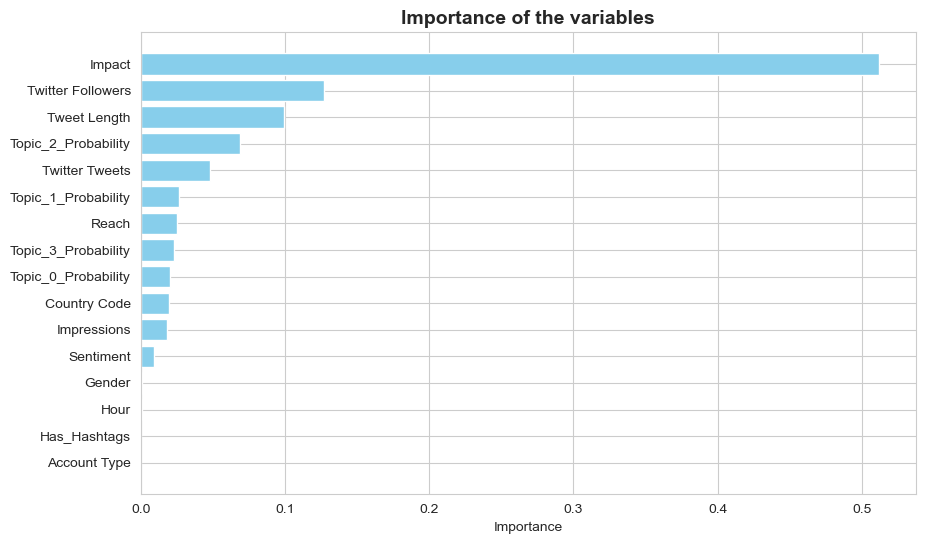

In [320]:
import matplotlib.pyplot as plt

# Ordenar las etiquetas y la importancia de manera descendente
etiquetas_importancia_sorted = [x for _,x in sorted(zip(importancia, etiquetas))]
importancia_sorted = sorted(importancia)

# Crear el gráfico de barras horizontal
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(etiquetas_importancia_sorted, importancia_sorted, color='skyblue')

# Añadir etiquetas y título
ax.set_xlabel('Importance')
ax.set_title('Importance of the variables', fontsize=14, fontweight='bold')

# Mostrar el gráfico
plt.show()

# Tweet Engagement - English Language

In [387]:
y = data_en['Engagement Category'].ravel()
columnas_a_eliminar = ['Engagement Category', 'Language', 'Author', 'Engagement Score' ,'Full Text', 'Tweet_Texts_Cleaned', 'Full Text Without Stopwords', 'tweet_final', 'Tweet_Tokenized', 'tweet', 'retweeted',	'mentioned',	'hashtags']
X = data_en.loc[:, ~data_en.columns.isin(columnas_a_eliminar)]
# Data final
columnas_a_eliminar = ['Language', 'Author', 'Engagement Score' ,'Full Text', 'Tweet_Texts_Cleaned', 'Full Text Without Stopwords', 'tweet_final', 'Tweet_Tokenized', 'tweet', 'retweeted',	'mentioned',	'hashtags']
datos = data_en.loc[:, ~data_en.columns.isin(columnas_a_eliminar)]



In [388]:
print("Data COP28 (English Language): ", datos.shape, "\n")

Data COP28 (English Language):  (770, 17) 



In [389]:
#Training-Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80 )

## Decision Tree

Métricas Arbol:
Precisión Global: 0.8506493506493507
Error Global: 0.14935064935064934
Precisión Positiva: 0.6428571428571429
Precisión Negativa: 0.8968253968253969


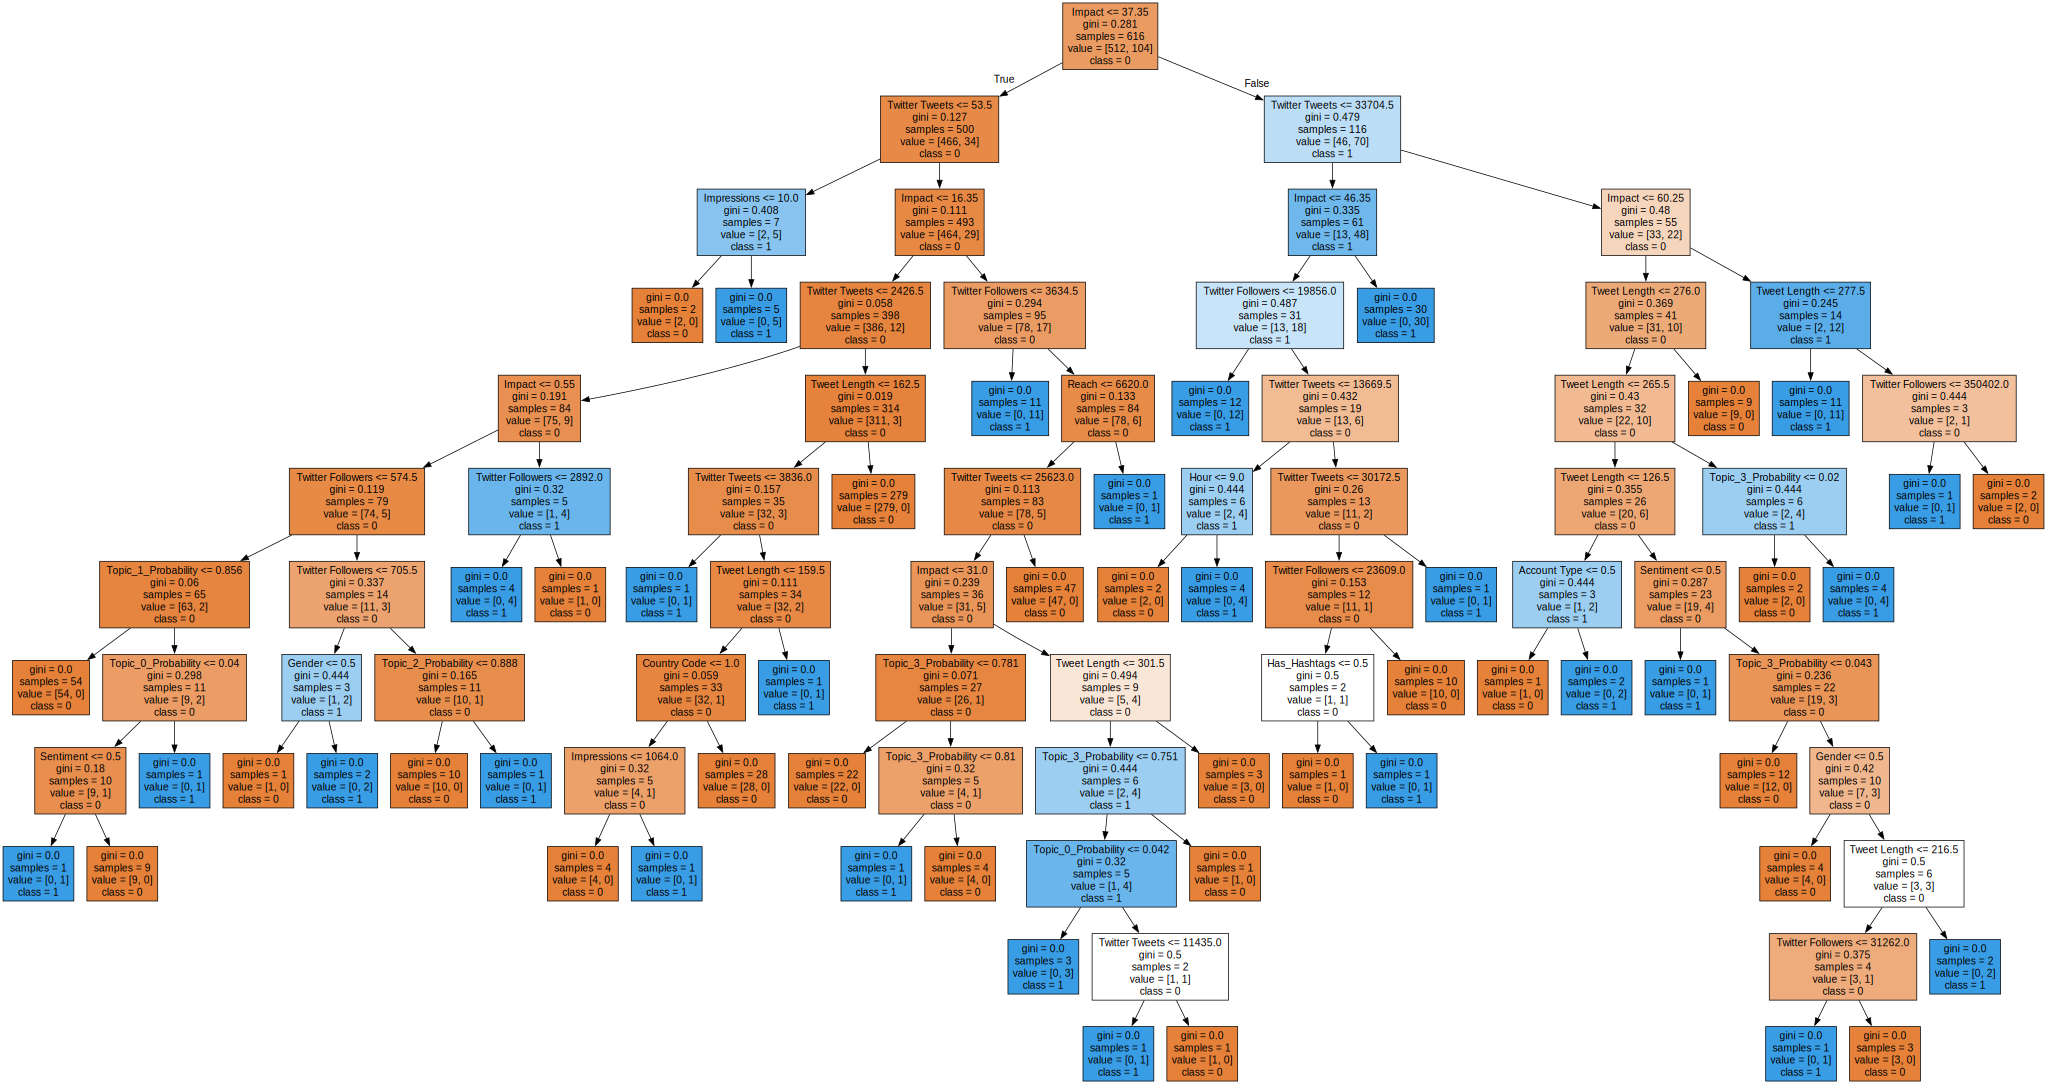

In [390]:
#Genera el modelo, las predicciones y mide la calidad de las mismas
instancia_arbol = DecisionTreeClassifier()
instancia_arbol.fit(X_train,y_train)
prediccion = instancia_arbol.predict(X_test)
MC_arbol = confusion_matrix(y_test, prediccion)

# Calcular la matriz de confusión utilizando las etiquetas verdaderas y las predicciones
MC_arbol = MC_arbol.ravel()
MC_arbol

calculator_arbol = MetricsCalculator(MC_arbol)
metrics_arbol = calculator_arbol.calculate_metrics()

print("Métricas Arbol:")
for metric, value in metrics_arbol.items():
    print(f"{metric}: {value}")

from sklearn.tree import export_graphviz
datos_plotear = export_graphviz(instancia_arbol, out_file=None,class_names=["0", "1"],
                feature_names=list(X.columns.values), filled=True)
grafico = graphviz.Source(datos_plotear, filename="arbol_booking", format="png") 
grafico.view()
grafico

In [391]:
# Genera el modelo de KNN
instancia_knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
instancia_knn.fit(X_train.values, y_train)
prediccion_knn = instancia_knn.predict(X_test.values)

# Calcular la matriz de confusión utilizando las etiquetas verdaderas y las predicciones
MC_knn = confusion_matrix(y_test, prediccion_knn)
MC_knn = MC_knn.ravel()

calculator_knn = MetricsCalculator(MC_knn)
metrics_knn = calculator_knn.calculate_metrics()

print("Métricas Knn:")
for metric, value in metrics_knn.items():
    print(f"{metric}: {value}")

Métricas Knn:
Precisión Global: 0.8441558441558441
Error Global: 0.1558441558441559
Precisión Positiva: 0.2857142857142857
Precisión Negativa: 0.9682539682539683


## Random Forest

In [392]:
#Construccion del modelo: Bosques Aleatorios
instancia_bosques = RandomForestClassifier(n_estimators = 155, criterion = "gini", min_samples_split = 2)

analisis_tweet = Analisis_Predictivo(datos,
                                       predecir = 'Engagement Category',
                                       modelo   = instancia_bosques,
                                       train_size = 0.80)
#Evaluacion modelo
resultados = analisis_tweet.fit_predict_resultados()

# Matriz de confusion Random Forest
matriz_confusion = resultados['Matriz de Confusión']

# Extraer los valores de la matriz de confusión
TP = matriz_confusion[0][0]
FP = matriz_confusion[0][1]
FN = matriz_confusion[1][0]
TN = matriz_confusion[1][1]
# Crear un vector de 1x4 con los valores extraídos
MC_rf = [TP, FP, FN, TN]
# Metricas
calculator_rf = MetricsCalculator(MC_rf)
metrics_rf = calculator_rf.calculate_metrics()

print("Métricas Random Forest:")
for metric, value in metrics_rf.items():
    print(f"{metric}: {value}")


Matriz de Confusión:
[[125   4]
 [ 11  14]]

Precisión Global:
0.9025974025974026

Error Global:
0.09740259740259738

Precisión por categoría:
          0     1
0  0.968992  0.56
Métricas Random Forest:
Precisión Global: 0.9025974025974026
Error Global: 0.09740259740259738
Precisión Positiva: 0.56
Precisión Negativa: 0.9689922480620154


## Ada Boosting

In [393]:
# Construcción de modelo
# Instancia Ada Boosting
instancia_rf = RandomForestClassifier(min_samples_split = 17)

instancia_ada = AdaBoostClassifier(base_estimator = instancia_rf,
                                   n_estimators   = 170)

analisis_tweet2 = Analisis_Predictivo(datos, 
                                       predecir = "Engagement Category", 
                                       modelo   = instancia_ada,
                                       estandarizar = True,
                                       train_size   = 0.8)
#Evaluacion modelo
resultados2 = analisis_tweet2.fit_predict_resultados()

# Matriz de confusion Ada Boosting
matriz_confusion = resultados2['Matriz de Confusión']
# Extraer los valores de la matriz de confusión
TP = matriz_confusion[0][0]
FP = matriz_confusion[0][1]
FN = matriz_confusion[1][0]
TN = matriz_confusion[1][1]
# Crear un vector de 1x4 con los valores extraídos
MC_ab = [TP, FP, FN, TN]
# Metricas
calculator_ab = MetricsCalculator(MC_ab)
metrics_ab = calculator_ab.calculate_metrics()

print("Métricas Ada boosting:")
for metric, value in metrics_ab.items():
    print(f"{metric}: {value}")


Matriz de Confusión:
[[121   9]
 [ 13  11]]

Precisión Global:
0.8571428571428571

Error Global:
0.1428571428571429

Precisión por categoría:
          0         1
0  0.930769  0.458333
Métricas Ada boosting:
Precisión Global: 0.8571428571428571
Error Global: 0.1428571428571429
Precisión Positiva: 0.4583333333333333
Precisión Negativa: 0.9307692307692308


## XG Boosting

In [394]:
#Construcción de modelo
instancia_gbc = GradientBoostingClassifier(n_estimators = 300, min_samples_split = 7)

analisis_tweet3 = Analisis_Predictivo(datos, 
                                       predecir = "Engagement Category", 
                                       modelo = instancia_gbc, 
                                       train_size = 0.8)
#Evaluacion modelo
resultados3 = analisis_tweet3.fit_predict_resultados()

# Matriz de confusion XGBoosting
matriz_confusion = resultados3['Matriz de Confusión']
# Extraer los valores de la matriz de confusión
TP = matriz_confusion[0][0]
FP = matriz_confusion[0][1]
FN = matriz_confusion[1][0]
TN = matriz_confusion[1][1]
# Crear un vector de 1x4 con los valores extraídos
MC_xg = [TP, FP, FN, TN]
# Metricas
calculator_xg = MetricsCalculator(MC_xg)
metrics_xg = calculator_xg.calculate_metrics()

print("Métricas XG boosting:")
for metric, value in metrics_xg.items():
    print(f"{metric}: {value}")


Matriz de Confusión:
[[125   4]
 [  5  20]]

Precisión Global:
0.9415584415584416

Error Global:
0.058441558441558406

Precisión por categoría:
          0    1
0  0.968992  0.8
Métricas XG boosting:
Precisión Global: 0.9415584415584416
Error Global: 0.058441558441558406
Precisión Positiva: 0.8
Precisión Negativa: 0.9689922480620154


In [395]:
data = {
    'Predictive Model': ['KNN', 'Decision Tree', 'Random Forest', 'Ada Boosting', 'XGBoosting'],
    'Global Precision': [metrics_knn['Precisión Global'], metrics_arbol['Precisión Global'], metrics_rf['Precisión Global'], metrics_ab['Precisión Global'], metrics_xg['Precisión Global']],
    'Overall Error': [metrics_knn['Error Global'], metrics_arbol['Error Global'], metrics_rf['Error Global'], metrics_ab['Error Global'], metrics_xg['Error Global']],
    'Positive Precision': [metrics_knn['Precisión Positiva'], metrics_arbol['Precisión Positiva'], metrics_rf['Precisión Positiva'], metrics_ab['Precisión Positiva'], metrics_xg['Precisión Positiva']],
    'Negative Precision': [metrics_knn['Precisión Negativa'], metrics_arbol['Precisión Negativa'], metrics_rf['Precisión Negativa'], metrics_ab['Precisión Negativa'], metrics_xg['Precisión Negativa']]
}

# DataFrame
comparacion_modelos = pd.DataFrame(data)
comparacion_modelos.style.set_caption("<b>Model Comparison - English Language</b>")

,Predictive Model,Global Precision,Overall Error,Positive Precision,Negative Precision
0,KNN,0.844156,0.155844,0.285714,0.968254
1,Decision Tree,0.850649,0.149351,0.642857,0.896825
2,Random Forest,0.902597,0.097403,0.560000,0.968992
3,Ada Boosting,0.857143,0.142857,0.458333,0.930769
4,XGBoosting,0.941558,0.058442,0.800000,0.968992


## Variable importance of the best model

In [398]:
#Obtenemos valores
importancia = np.array(analisis_tweet3.modelo.feature_importances_)
etiquetas   = np.array(analisis_tweet3.predictoras)

#Ordenar
orden       = np.argsort(importancia)
importancia = importancia[orden]
etiquetas   = etiquetas[orden]

print("Importancia de las variables: ",importancia, "\n")

Importancia de las variables:  [0.00087299 0.00148902 0.00295742 0.00567974 0.00602654 0.00712474
 0.01310227 0.0257472  0.03074088 0.03429624 0.04088849 0.05403993
 0.05915989 0.11002901 0.11076277 0.49708286] 



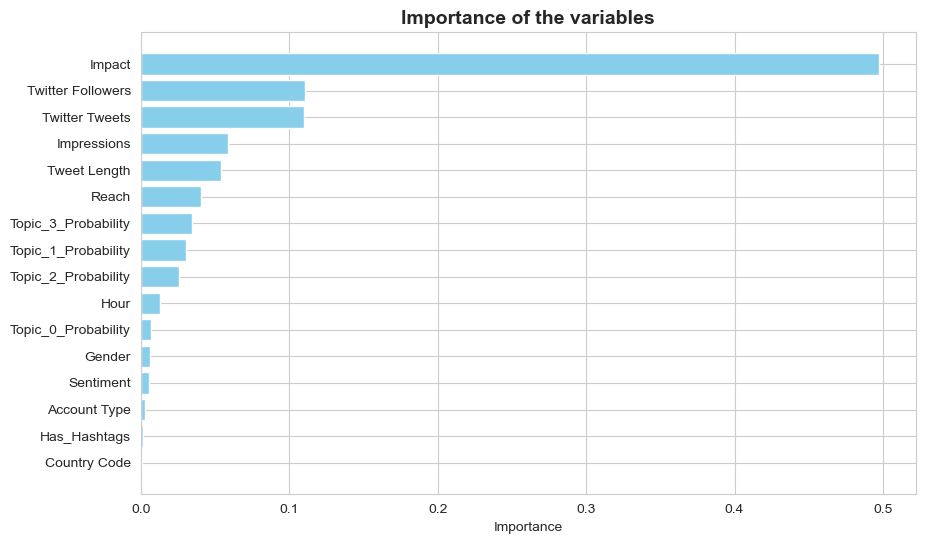

In [399]:
import matplotlib.pyplot as plt

# Ordenar las etiquetas y la importancia de manera descendente
etiquetas_importancia_sorted = [x for _,x in sorted(zip(importancia, etiquetas))]
importancia_sorted = sorted(importancia)

# Crear el gráfico de barras horizontal
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(etiquetas_importancia_sorted, importancia_sorted, color='skyblue')

# Añadir etiquetas y título
ax.set_xlabel('Importance')
ax.set_title('Importance of the variables', fontsize=14, fontweight='bold')

# Mostrar el gráfico
plt.show()